# Setup Models

In [1]:
from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings, AmazonKnowledgeBasesRetriever
import boto3

session = boto3.Session(profile_name="default")
bedrock_client = session.client('bedrock-runtime')

model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
# model_id = 'anthropic.claude-3-5-sonnet-20240620-v1:0'
model_kwargs =  { 
        "max_tokens": 512,
        "temperature": 0,
        "top_p": 1,
}

# LangChain class for chat
model = ChatBedrock(
    client=bedrock_client,
    model_id=model_id,
    model_kwargs=model_kwargs,
)

# Engineer prompts for reflection

In [2]:
summarizer_prompt="""
You are an document summarizer who can summarize a document provide to you.
For the input provided, create a summary with less than 50 words.
If the user has provides critique, responsed with a revised version of your previous attempts
"""

reviewer_prompt="""
You are a reviewer grading summaries for an article. 
Compare the user input document and generated summary.
Check if the summary accurately reflects the contents of the document.
Provide recommendations for improvement in less than 50 words.
"""

# Setup the summary-with-review Agent

In [3]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class SummaryAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class SummaryAgent:
    
    def __init__(self, model, summarizer_prompt, reviewer_prompt, debug=False):
        
        self.model=model
        self.summarizer_prompt=summarizer_prompt
        self.reviewer_prompt=reviewer_prompt
        self.debug=debug
    
        summary_agent_graph=StateGraph(SummaryAgentState)
        summary_agent_graph.add_node("summarizer",self.generate_summary)
        summary_agent_graph.add_node("reviewer",self.review_summary)

        summary_agent_graph.add_conditional_edges(
            "summarizer",
            self.should_continue,
            {True: "reviewer", False: END }
        )
        summary_agent_graph.add_edge("reviewer", "summarizer")
        summary_agent_graph.set_entry_point("summarizer")

        #Add chat memory
        self.memory=MemorySaver()
        #Compile the graph
        self.summary_agent_graph = summary_agent_graph.compile(checkpointer=self.memory)

    def generate_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend summarizer system prompt to messages
        messages = [SystemMessage(content=self.summarizer_prompt)] + messages

        #invoke the summarizer with the message history
        result = self.model.invoke(messages)
        
        if self.debug:
            print(f"==============\n Generator returned output : {result.content}")
        return { "messages":[result] }
        
    def review_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend Reviewer system prompt to messages
        messages = [SystemMessage(content=self.reviewer_prompt)] + messages
        
        #invoke the reviewer with the message history
        result = self.model.invoke(messages)
        
        if self.debug:
            print(f"*************\n Reviewer returned output : {result.content}")
        return { "messages":[result] }
        
    def should_continue(self, state:SummaryAgentState):

        total_reviews = len(state["messages"]) / 2
        
        if self.debug:
            print(f"Iteration number : { total_reviews }")

        #Return if 2 iterations are completed. Each iteration has 2 messages
        if len(state["messages"]) > 4:
            return False
        else:
            return True

# Setup the summary-with-review Chatbot

In [4]:
from IPython.display import Image
from langchain_community.document_loaders import PyPDFLoader

#Setup the summary chatbot
summary_chatbot = SummaryAgent(model, 
                               summarizer_prompt, 
                               reviewer_prompt,
                               debug=True)

# Image(summary_chatbot.summary_agent_graph.get_graph().draw_mermaid_png())

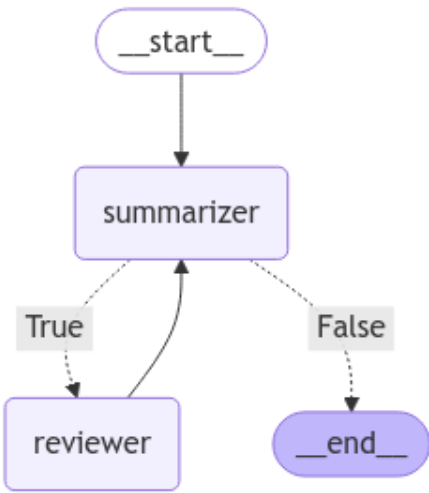

In [5]:
#Input file for execution
# Load, chunk and index the contents of the pdf.
from langchain_community.document_loaders import PyPDFLoader
loader=PyPDFLoader("./data/EcoSprint_Specification_Document.pdf")
docs = loader.load()

#Pick the first page of the doc as content
source_content=docs[0].page_content.replace("\n"," ")
print(f"Input :==============\n {source_content}\n")

Input :==============
 EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandresponsivedrivingexperience.● Ba

# Execute the summary-with-review chatbot

In [6]:
import uuid
#Execute a single request with debug ON
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

messages=[HumanMessage(content=source_content)]
result=summary_chatbot.summary_agent_graph.invoke({"messages":messages},config)

 Generator returned output : Here is a 49-word summary of the EcoSprint Specification document:

The EcoSprint is a high-performance electric vehicle with a sleek, aerodynamic design, a spacious and luxurious interior, and advanced features like a powerful electric motor, long-range battery, state-of-the-art infotainment, and comprehensive safety and security systems.
Iteration number : 1.0


Error raised by bedrock service
Traceback (most recent call last):
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/langchain_aws/llms/bedrock.py", line 935, in _prepare_input_and_invoke
    response = self.client.invoke_model(**request_options)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 570, in _api_call
    return self._make_api_call(operation_name, kwargs)
           ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/context.py", line 123, in wrapper
    return func(*args, **kwargs)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 1031, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: messages: roles must alternate between "u

*************
 Reviewer returned output : 

Recommendations for improvement:
The summary could be further condensed to highlight the key specifications and features more concisely.


ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: messages: roles must alternate between "user" and "assistant", but found multiple "assistant" roles in a row

In [ ]:
#Take user feedback on the summary through a chatbot
summary_chatbot = SummaryAgent(model, 
                               summarizer_prompt, 
                               reviewer_prompt,
                               debug=False)


user_inputs = [
    source_content,
    "Can you rewrite the review by focusing more on the specifications?",
    "Can you remove details about the touchscreen?"
]

#Create a new thread
config = {"configurable": {"thread_id": "thread-summarizer"}}

#Given the number of iterations, this will take a long time.
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = summary_chatbot.summary_agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")